In [1]:
# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore')

# Common imports
import pandas as pd
import numpy as np

#Clustering imports
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# To format floats
from IPython.display import display
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
df_aisles = pd.read_csv("../data/raw/aisles.csv")
df_orders = pd.read_csv("../data/raw/orders.csv")
df_products = pd.read_csv("../data/raw/products.csv")
df_order_products__prior = pd.read_csv("../data/raw/order_products__prior.csv")

In [3]:
cluster_df = pd.merge(pd.merge(pd.merge(df_order_products__prior, df_products, on="product_id"),\
                        df_orders, on="order_id"), df_aisles, on="aisle_id")
cluster_df.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.00000,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.00000,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.00000,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.00000,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.00000,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.00000,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.00000,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.00000,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.00000,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.00000,eggs


We'll cluster clients based on the aisles of their products bought to have a smaller dataframe, since clustering based on products takes too much memory.

In [4]:
cluster_df = pd.crosstab(cluster_df['user_id'], cluster_df['aisle'])
cluster_df.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,5
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,19


In [5]:
cluster_df.shape

(206209, 134)

In [6]:
cluster_df.to_pickle('../data/interim/cluster_df.pkl')

### PCA on clusters

Using the Principal Component Analysis in the crosstab dataframe will reduce the number of aisles to any given number.

In [7]:
pca = PCA(n_components=5)
pca.fit(cluster_df)
pca_samples = pca.transform(cluster_df)

In [8]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4
0,-24.21566,2.42943,-2.46637,-0.14568,0.26910
1,6.46321,36.75112,8.38255,15.09753,-6.92094
2,-7.99030,2.40438,-11.03006,0.67223,-0.44241
3,-27.99113,-0.75582,-1.92173,2.09189,-0.28822
4,-19.89639,-2.63722,0.53323,3.67923,0.61281


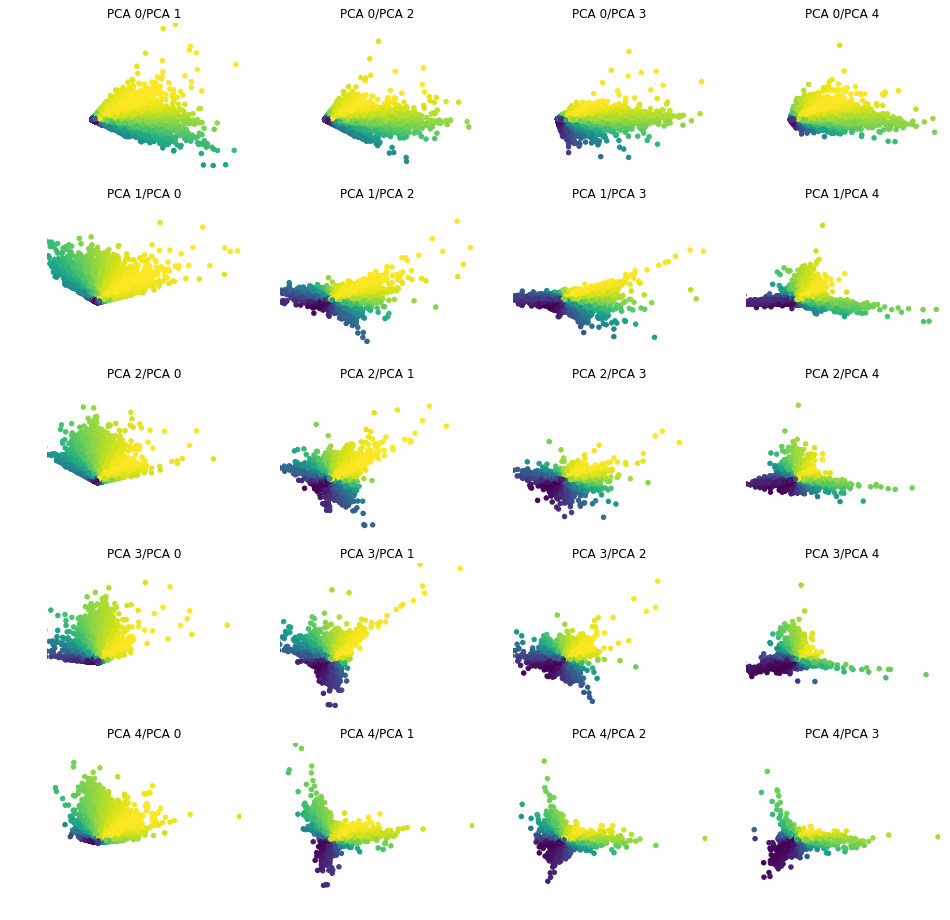

In [9]:
plt.figure(figsize=(16,16))

i=1
for column1 in range(0,5):
    for column2 in range(0,5):
        if column1!=column2:
            matXY = ps[[column1,column2]].as_matrix()
            simCosine = 1. - cdist(matXY, [[1,1]], 'cosine')

            ax = plt.subplot(5,4,i)
            ax.scatter(ps[column1], ps[column2], c=simCosine.T[0], s=20)
            plt.ylim([-500,900])
            plt.xlim([-250,700])
            plt.axis('off')
            plt.title('PCA {}/PCA {}'.format(column1,column2))
            i+=1
        
plt.show();

One of the most interesting relationships seem to be PCA 4/PCA 1. Let's explore it in more detail.

In [10]:
matXY = ps[[4,1]].as_matrix()
simCosine = 1. - cdist(matXY, [[1,1]], 'cosine')

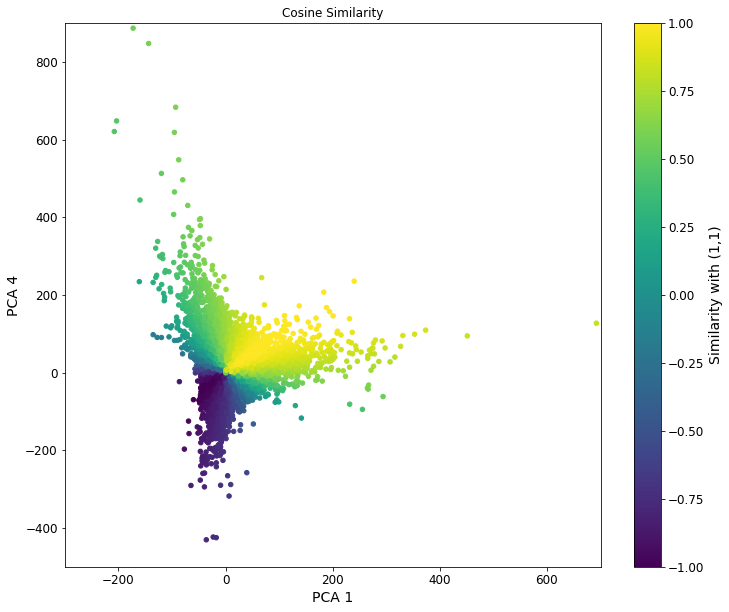

In [11]:
plt.figure(figsize=[12,10])
plt.scatter(matXY[:,0], matXY[:,1], c=simCosine.T[0], s=20)
plt.ylim([-500,900])
plt.xlim([-300,700])
plt.xlabel('PCA 1')
plt.ylabel('PCA 4')
plt.title('Cosine Similarity')
cb = plt.colorbar()
cb.set_label('Similarity with (1,1)', size=14)
plt.show();

### Chebyshev Distance

In [12]:
distChebyshev = np.maximum(np.abs(matXY[:, 0]), np.abs(matXY[:, 1]))

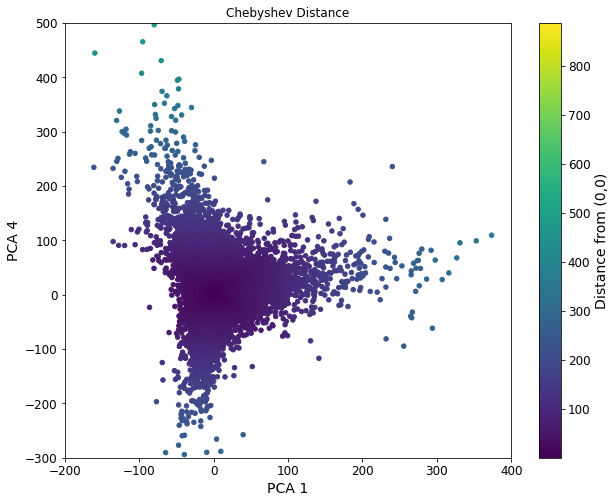

In [13]:
plt.figure(figsize=[10,8])

plt.scatter(matXY[:, 0], matXY[:, 1], c=distChebyshev, s=20)
plt.ylim([-300,500])
plt.xlim([-200,400])
plt.xlabel('PCA 1')
plt.ylabel('PCA 4')
plt.title('Chebyshev Distance')
cb = plt.colorbar()
cb.set_label('Distance from (0,0)', size=14)

In [15]:
clusterer = KMeans(n_clusters=6).fit(matXY)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(matXY)
print(centers)

[[ -2.04651768e+00  -1.91031800e+01]
 [ -3.97575636e+00   3.58358682e+01]
 [ -3.67312103e+01   1.59384094e+02]
 [  1.22771800e-01   4.28227048e-01]
 [  8.31494552e+01   2.73182168e+01]
 [ -9.00700861e+00  -7.58995500e+01]]


In [16]:
print (c_preds[0:100])

[3 1 3 3 3 3 3 0 3 0 3 3 3 0 3 0 3 3 3 3 1 0 3 3 3 3 2 0 3 3 3 3 3 3 3 3 0
 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 0 3 3 3
 0 3 3 3 3 3 3 3 3 3 3 0 3 3 0 1 3 3 3 3 3 3 3 3 3 3]


Here is how our clusters appear

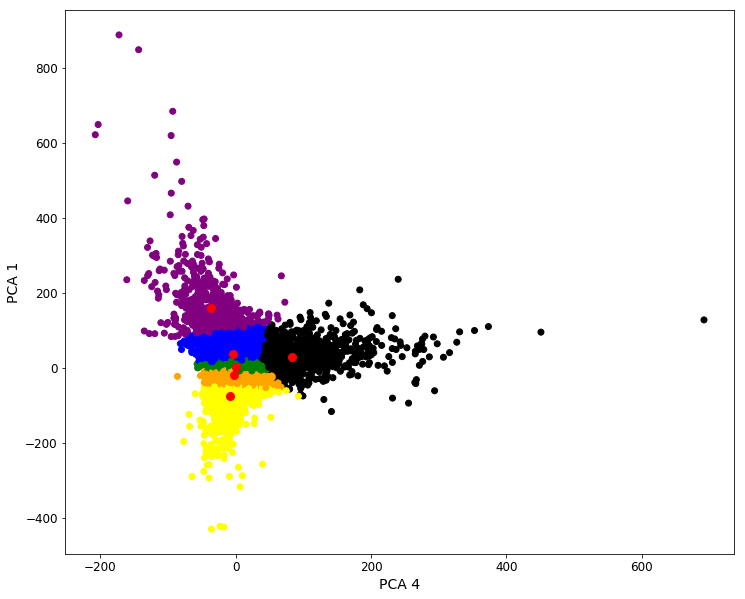

In [17]:
fig = plt.figure(figsize=(12,10))
colors = ['orange','blue','purple','green','black','yellow']
colored = [colors[k] for k in c_preds]

plt.scatter(matXY[:,0], matXY[:,1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red')

plt.xlabel('PCA 4')
plt.ylabel('PCA 1')
plt.show()

We have found a possible clustering for our customers.

### Dendogram

In [18]:
#Reduce the matrix for the sake of memory
matXY = matXY[:10000]

In [19]:
link_mat = linkage(matXY, 'ward')
print(link_mat.shape)
clusters = fcluster(link_mat, 6, criterion='maxclust')

(9999, 4)


"Elbow" method for Hierarchical Clustering

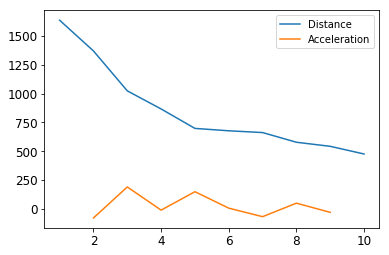

In [20]:
last_merges = link_mat[-10:, 2]
last_merges_rev = last_merges[::-1]
idx = np.arange(1, len(last_merges) + 1)
plt.plot(idx, last_merges_rev, label='Distance')

acceleration = np.diff(last_merges, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idx[:-2] + 1, acceleration_rev, label='Acceleration')
plt.legend()
plt.show()

We can see how the distance has an elbow at around 6, where distance starts decreasing very slowly and acceleration is only decreasing from there onwards.

In [21]:
# Find the distance at which to cut off the dendrogram for 
# a given number of clusters
def findDendrogramCut(ddata, n_cluster):
    hierarch_dist = np.matrix(ddata['dcoord'])
    sorted_hierarch_dist = hierarch_dist[np.argsort(hierarch_dist.A[:,1])]
    d_cut = sorted_hierarch_dist[-n_cluster:-n_cluster+2][:,1].sum() / 2.
    return d_cut

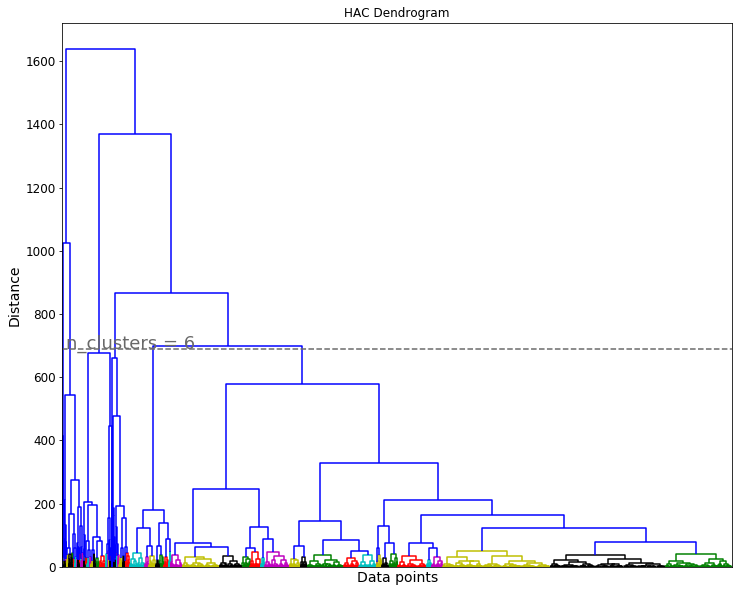

In [22]:
# Plotting a dendrogram
figDenDroXZ = plt.figure(figsize=(12,10))

ddata = dendrogram(link_mat, leaf_rotation=90., no_labels=True, color_threshold=50)
dist_cut = findDendrogramCut(ddata, 6)
plt.axhline(y=dist_cut, linestyle='--', c='dimgray')
plt.text(np.min(ddata['icoord'])*100, dist_cut+2, 'n_clusters = 6', size=18, color='dimgray')
plt.title('HAC Dendrogram',)
plt.xlabel('Data points')
plt.ylabel('Distance')
plt.show();

### Clusters. Initialization and Choosing _k_

Clean data:

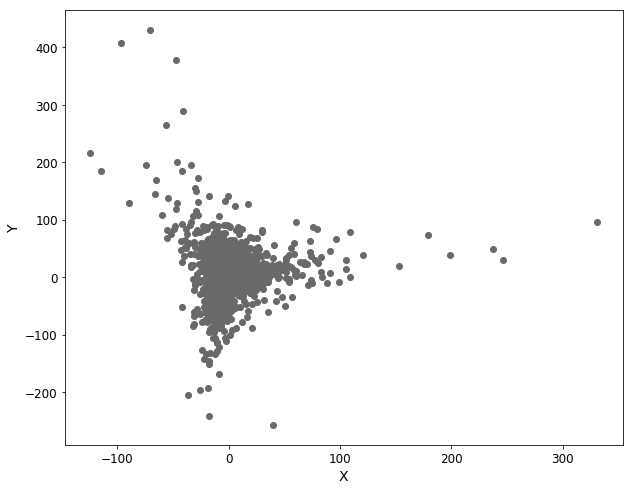

In [23]:
plt.figure(figsize=(10,8))

plt.scatter(matXY[:,0], matXY[:,1], c='dimgray')
plt.xlabel('X', size=14)
plt.ylabel('Y', size=14)
plt.show();

In [24]:
def test(data, nClusterRange):
    inertias = np.zeros(len(nClusterRange))
    for i in range(len(nClusterRange)):
        model = KMeans(n_clusters=i+1, init='k-means++').fit(data)
        inertias[i] = model.inertia_
    return inertias

In [25]:
kRange = range(1,12)
testKmeanXY = test(matXY, kRange)

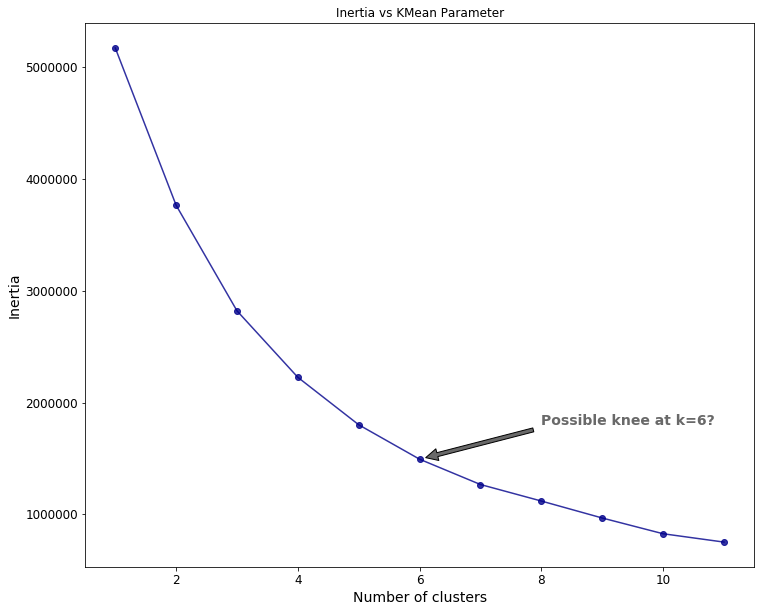

In [26]:
plt.figure(figsize=(12,10))

plt.plot(kRange, testKmeanXY, 'o-', color='darkblue', alpha=0.8)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs KMean Parameter')
plt.annotate('Possible knee at k=6?', xy=(6, testKmeanXY[5]), xytext=(8,testKmeanXY[4]),
             size=14, weight='bold', color='dimgray',
             arrowprops=dict(facecolor='dimgray', shrink=0.05))
plt.show();

### Balancing Inertia with Entropy

In [27]:
# Computing Akaike and Bayes Information Criteria
def kmeansIC(model):
    k, m = model.cluster_centers_.shape
    n, = model.labels_.shape
    D = model.inertia_
    return {'AIC': D + 2*m*k, 'BIC': D + np.log(n)*m*k}

# Computing Renyi and Shannon Entropies
def kmeansRenyi(model):
    n, = model.labels_.shape
    nClusters, m = model.cluster_centers_.shape
    max_p = np.max([ model.labels_[model.labels_ == k].shape[0] for k in range(nClusters)]) / float(n)
    return - np.log2(max_p)

def kmeansEntropy(model):
    n, = model.labels_.shape
    nClusters, m = model.cluster_centers_.shape
    p = np.array([ model.labels_[model.labels_ == k].shape[0] for k in range(nClusters)]) / float(n)
    return - np.sum(p * np.log2(p))

In [28]:
# Small test function to calculate all our model estimators 
# in function of the number of cluster in k-means.
def newTest(data, nClusterRange):
    nClusters = len(nClusterRange)
    inertias = np.zeros(nClusters)
    BICs = np.zeros(nClusters)
    AICs = np.zeros(nClusters)
    Hrenyis = np.zeros(nClusters)
    entropies = np.zeros(nClusters)
    for i in range(len(nClusterRange)):
        model = KMeans(n_clusters=i+1, init='k-means++').fit(data)
        inertias[i] = model.inertia_
        AICs[i] = kmeansIC(model)['AIC']
        BICs[i] = kmeansIC(model)['BIC']
        Hrenyis[i] = kmeansRenyi(model)
        entropies[i] = kmeansEntropy(model)
    return {'inertias': inertias, 'AICs': AICs, 'BICs': BICs, 'Hrenyis': Hrenyis, 'entropies': entropies}

In [29]:
testResXY = newTest(matXY, range(1,30))

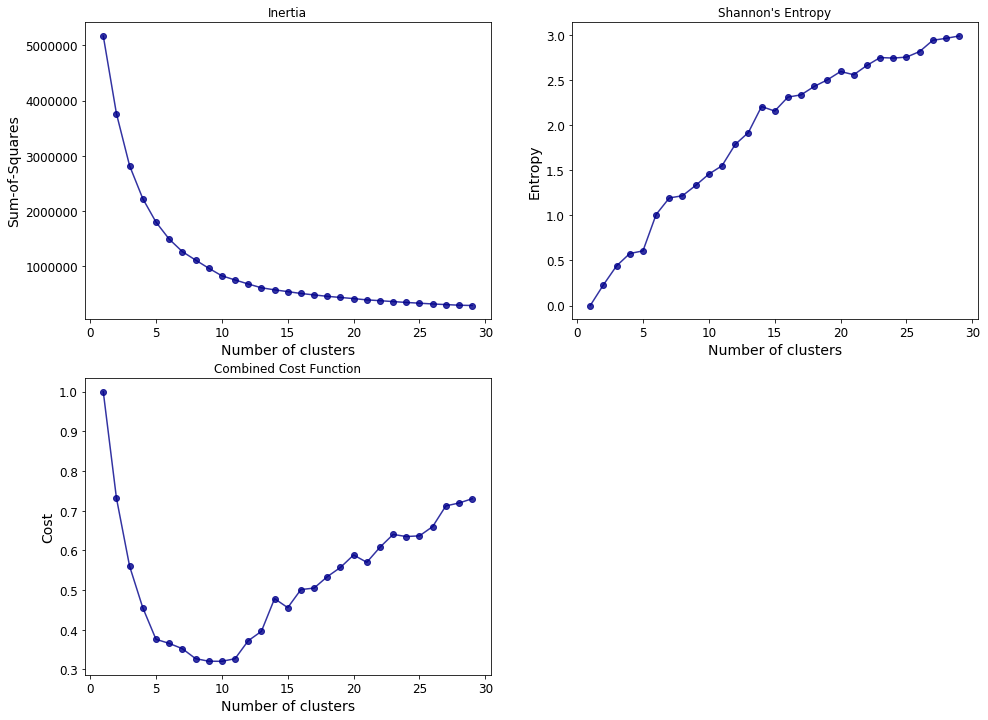

In [30]:
plt.figure(figsize=(16,12))

norm_inertias = testResXY['inertias'][0]
norm_entropies = - np.log2(1./len(matXY))

ax1 = plt.subplot('221')
ax1.plot(range(1,30),testResXY['inertias'], 'o-', color='darkblue', alpha=0.8)
plt.title('Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('Sum-of-Squares')

ax2 = plt.subplot('222')
ax2.plot(range(1,30), testResXY['entropies'], 'o-', color='darkblue', alpha=0.8)
plt.title("Shannon's Entropy")
plt.xlabel('Number of clusters')
plt.ylabel('Entropy')

ax3 = plt.subplot('223')
ax3.plot(range(1,30), testResXY['inertias']/norm_inertias + testResXY['entropies']**2/norm_entropies, \
         'o-', color='darkblue', alpha=0.8)
plt.title('Combined Cost Function')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')

plt.show();

Based on the combined cost functions, there could be an optimum in 8 clusters

### Density

In [31]:
pairDistList = pdist(matXY)

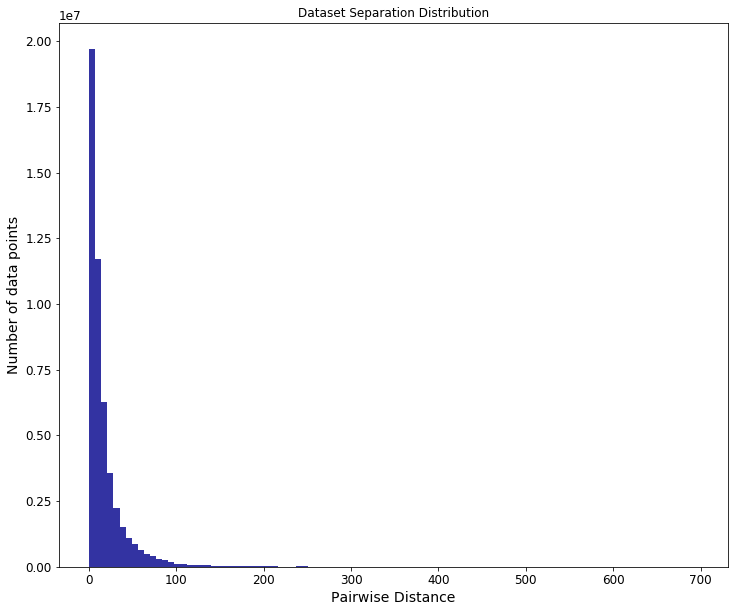

In [32]:
plt.figure(figsize=(12,10))
plt.hist(pairDistList, bins=100, color='darkblue', alpha=0.8)
plt.xlabel('Pairwise Distance')
plt.ylabel('Number of data points')
plt.title('Dataset Separation Distribution')
plt.show();

In [33]:
def neighborhoods(data, epsilon):
    n_data = data.shape[0]
    nn = np.zeros(n_data)
    # Compute all - n(n-1)/2 - pairwise distances
    pMat = pdist(data)
    # Compute the (i,j) indexes of pairs that correspond to each elements in pMat
    indexes = np.array([ (i,j) for i in range(n_data) for j in range(i+1, n_data)])
    # Find pairs of data points that are closer than epsilon
    pairs = indexes[np.where(pMat < epsilon)]
    for pair in pairs:
        nn[pair[0]] += 1
        nn[pair[1]] += 1
    return nn

In [34]:
nn = neighborhoods(matXY, 0.6)

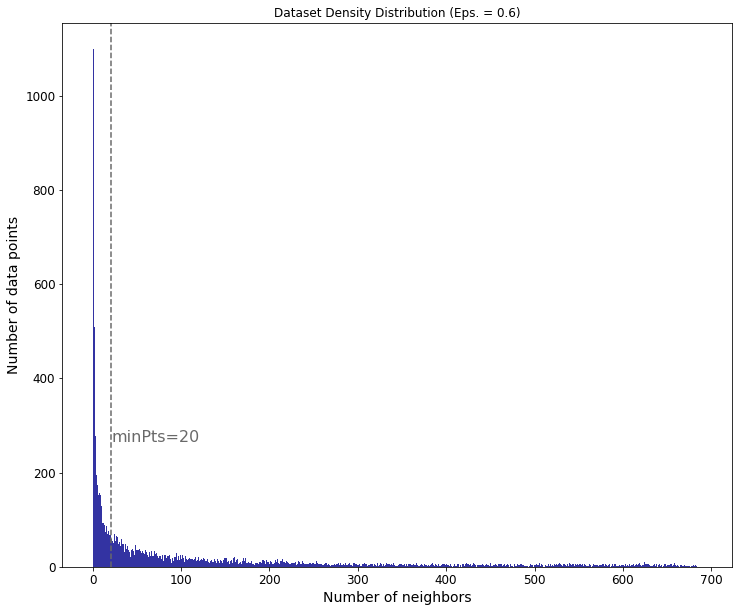

In [35]:
plt.figure(figsize=(12,10))

plt.hist(nn, bins=np.arange(min(nn), max(nn) + 1, 1), color='darkblue', alpha=0.8)
plt.xlabel('Number of neighbors')
plt.ylabel('Number of data points')
plt.title('Dataset Density Distribution (Eps. = 0.6)')
plt.text(21, 265, 'minPts=20', size=16, color='dimgray')
plt.axvline(x=20.5, linestyle='--', color='dimgray')
plt.show();

### DBSCAN Algorithm

In [36]:
# Conclusion
epsilon = 0.6
min_samples = 15

dbmodel = DBSCAN(eps=epsilon, min_samples=min_samples).fit(matXY)

In [37]:
labels = dbmodel.labels_
print(set(labels))

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)

{0, 1, 2, 3, 4, 5, -1}
6


In [38]:
# Build a dictionary of clusters
def buildClusterDict(model):
    npts = model.labels_.shape[0]
    clusterDict = {}
    for i in range(npts):
        lbl = model.labels_[i]
        if lbl in clusterDict:
            clusterDict[lbl].append(i)
        else:
            clusterDict[lbl] = [i]
    return clusterDict

In [39]:
clusterDict = buildClusterDict(dbmodel)

In [40]:
# Cluster Statistics verbose report
for lbl in clusterDict:
    if lbl != -1:
        print("Cluster {0} has {1} members".format(lbl, len(clusterDict[lbl])))

print("Model identified {0} data points as noise".format(len(clusterDict[-1])))

Cluster 0 has 6768 members
Cluster 2 has 22 members
Cluster 3 has 15 members
Cluster 4 has 19 members
Cluster 1 has 20 members
Cluster 5 has 15 members
Model identified 3141 data points as noise


In [41]:
# Number of Core samples
print(dbmodel.core_sample_indices_.shape)

(6445,)


In [42]:
# noise data point mask
n_data = matXY.shape[0]
noise_sample_mask = np.zeros(n_data, dtype=bool)
noise_sample_mask[clusterDict[-1]] = True

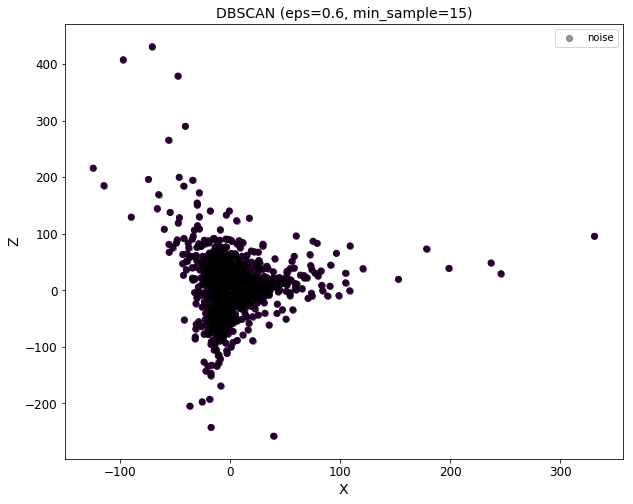

In [43]:
plt.figure(figsize=(10,8))

plt.scatter(matXY[:,0], matXY[:,1], c=dbmodel.labels_)
plt.scatter(matXY[noise_sample_mask, 0], matXY[noise_sample_mask, 1], c='k', alpha=0.4, label="noise")
plt.xlabel('X', size=14)
plt.ylabel('Z', size=14)
plt.legend()
plt.title('DBSCAN (eps='+str(epsilon)+', min_sample='+str(min_samples)+')', size=14)
plt.show();

In [44]:
epsilons = np.arange(0.2,5.0,0.5)
min_samples = np.arange(15,50,5)

In [45]:
class DBSCANModel(DBSCAN):
    def buildClusterDict(self):
        self.clusterDict = buildClusterDict(self)
    
    def summary(self):
        self.summary = {
            'epsilon': self.eps,
            'minPts': self.min_samples,
            'noise_pts': 0 if -1 not in self.clusterDict else len(self.clusterDict[-1]),
            'n_clusters': len(set(self.clusterDict.keys()))-1
        }
        

class ModelList(object):
    def __init__(self, epsilons, min_samples):
        self.epsilons = epsilons
        self.min_samples = min_samples
        self.models=[]
        self.clusterDicts=[]
        self.summaries=[]
    
    def fit(self, data):
        for epsilon in self.epsilons:
            for min_sample in self.min_samples:
                model = DBSCANModel(eps=epsilon, min_samples=min_sample).fit(data)
                self.models.append(model)
                
    def buildClusterDicts(self):
        for model in self.models:
            model.buildClusterDict()
            self.clusterDicts.append(model.clusterDict)
            
    def summary(self):
        for model in self.models:
            model.summary()
            self.summaries.append(model.summary)
                    

In [46]:
ml = ModelList(epsilons, min_samples)

In [47]:
ml.fit(matXY)

In [48]:
ml.buildClusterDicts(); ml.summary()

In [49]:
summary_DF = pd.DataFrame(ml.summaries)
summary_DF.sort_values(by='noise_pts', inplace=True)
summary_DF.head()

,epsilon,minPts,n_clusters,noise_pts
63,4.70000,15,1,485
56,4.20000,15,1,551
64,4.70000,20,1,552
65,4.70000,25,1,611
49,3.70000,15,1,617


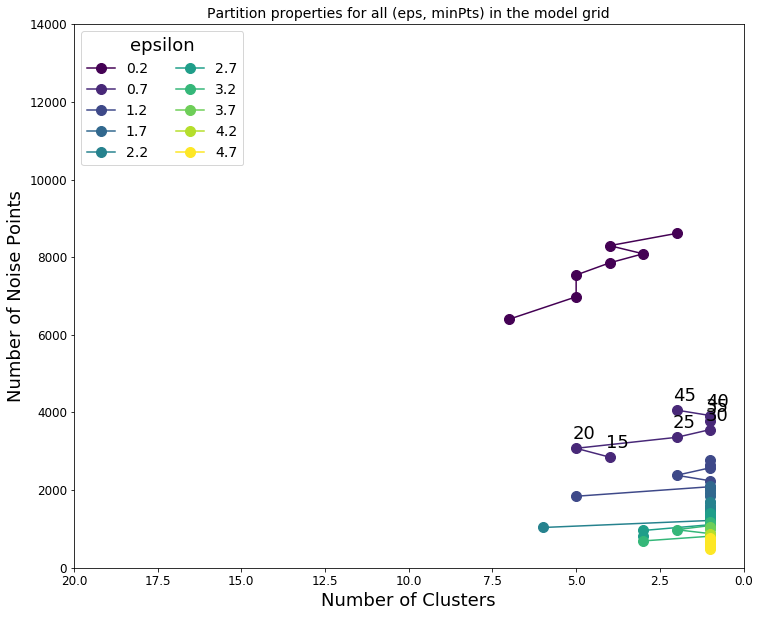

In [58]:
# We will color according to (eps / minPts) and need some color map normalization
norm = mpl.colors.Normalize(vmin=summary_DF['epsilon'].min(),vmax=summary_DF['epsilon'].max())

figRefineDBSCAN = plt.figure(figsize=(12,10))

ax = figRefineDBSCAN.add_subplot('111')
for eps in epsilons:
    summary_DF[summary_DF['epsilon'] == eps].plot.line(x='n_clusters', y='noise_pts', \
                                                         ax=ax, marker='o', c=cm.viridis(norm(eps)), \
                                                         label=str(eps), markersize=10)    

# Annotate one serie of models with minPts values
annotate_DF = summary_DF[summary_DF['epsilon'] == epsilons[1]][['n_clusters', 'noise_pts']]
iter = 0
for k, v in annotate_DF.iterrows():
    ax.annotate(min_samples[iter], v, xytext=(-4,9), textcoords='offset points', size=18)
    iter += 1

# A few plot elements to adjust the rendition
plt.xlim([20,0])
plt.ylim([-1,14000])
plt.ylabel('Number of Noise Points', size=18)
plt.xlabel('Number of Clusters', size=18)
plt.title('Partition properties for all (eps, minPts) in the model grid', size=14)
legend = plt.legend(loc="upper left", title="epsilon", ncol=2, fontsize=14)
plt.setp(legend.get_title(),fontsize=18)

plt.show();